# 500 Species Bird Classification
by Daniel Glownia 

In this notebook I use transfer learning and supervised learning fit the 500 species bird classification dataset found on Kaggle. The data set is around 80k images. I use MobileNetV3Small and MobileNetV3Large as my base model.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
import os.path
from sklearn.metrics import classification_report, confusion_matrix
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/ml_final/"
!ls "/content/drive/My Drive/ml_final"

Mounted at /content/drive
archive
archive.zip
history_2023-03-08_19:01:49.007284.csv
model_bird_2023-03-05_18:47:00.865455.h5
model_bird_2023-03-05_20:21:09.026340.h5
model_bird_2023-03-05_21:23:56.674497.h5
model_bird_2023-03-06_02:48:10.768076.h5
model_bird_2023-03-06_05:39:41.448853.h5
model_bird_2023-03-06_05:53:27.594264.h5
model_bird_2023-03-06_09:00:23.666948.h5
model_bird_2023-03-06_15:21:31.478167.h5
model_bird_2023-03-08_19:01:49.007284.h5
model_saves


In [ ]:
!unzip -q "/content/drive/My Drive/ml_final/archive.zip"

In [ ]:
!ls "/content/drive/My Drive/ml_final"

archive
archive.zip
history_2023-03-08_19:01:49.007284.csv
model_bird_2023-03-05_18:47:00.865455.h5
model_bird_2023-03-05_20:21:09.026340.h5
model_bird_2023-03-05_21:23:56.674497.h5
model_bird_2023-03-06_02:48:10.768076.h5
model_bird_2023-03-06_05:39:41.448853.h5
model_bird_2023-03-06_05:53:27.594264.h5
model_bird_2023-03-06_09:00:23.666948.h5
model_bird_2023-03-06_15:21:31.478167.h5
model_bird_2023-03-08_19:01:49.007284.h5
model_saves


In [ ]:
!ls

 birds.csv	      info.txt					    test
 drive		     'mobilenetv3-small-500-(224 X 224)-98.68.h5'   train
'images to predict'   sample_data				    valid


In [ ]:

image_dir = Path('./test')
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

test_df = pd.concat([filepaths, labels], axis=1)

image_dir = Path('./train')
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

train_df = pd.concat([filepaths, labels], axis=1)

image_dir = Path('./valid')
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

valid_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
print(valid_df.shape)
print(test_df.shape)
print(train_df.shape)

(2500, 2)
(2500, 2)
(80085, 2)


In [ ]:
# Transform Data and load into image data object 

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

valid_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)

valid_images = valid_generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 80085 validated image filenames belonging to 500 classes.
Found 2500 validated image filenames belonging to 500 classes.
Found 2500 validated image filenames belonging to 500 classes.


In [ ]:
#Fit the model

In [ ]:
# Create checkpoint callback
checkpoint_path = "/content/drive/My Drive/ml_final/model_saves/bird_final_at_{epoch}.keras"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
# Resize Layer
color_correction = tf.keras.Sequential([
  layers.RandomFlip(),
  layers.RandomBrightness(factor=0.3,value_range=(0, 1)),
  layers.RandomContrast(factor=0.3),
  layers.RandomRotation(factor=0.25),
  layers.RandomZoom(height_factor=(-0.2, 0.2))
])

processing_layers = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
# Read in Dataset to see the images (not used for training)

In [ ]:
image_size = (224, 224)

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "./test",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
)

Found 2500 files belonging to 500 classes.
Using 2000 files for training.
Using 500 files for validation.


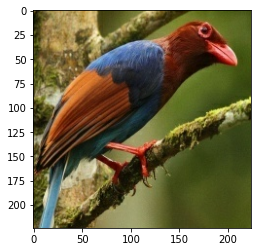

In [ ]:
image, label = next(iter(train_ds))
plt.imshow(image[0].numpy().astype("uint8"))

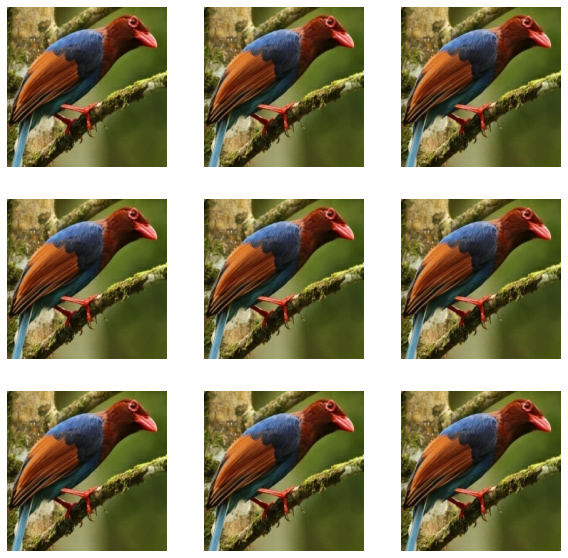

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = processing_layers(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV3Small(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [ ]:
# Model with Many Layers 

In [ ]:
epochs = 2
batch_size = 256

inputs = pretrained_model.input
x = processing_layers(inputs)

x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

previous_block_activation = x  # Set aside residual

for size in [256, 512, 728]:
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
    residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
    x = layers.add([x, residual])  # Add back residual
    previous_block_activation = x  # Set aside next residual

x = layers.SeparableConv2D(1024, 3, padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2DTranspose(8, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2DTranspose(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = layers.Conv2D(8, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = layers.BatchNormalization()(x)

x = layers.Activation("relu")(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(500, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

history = model.fit(
    train_images,
    batch_size = batch_size,
    validation_data=valid_images,
    epochs=epochs,
    callbacks=[
        checkpoint_callback,
    ],
    use_multiprocessing=True
)

time_stamp_name = str(datetime.now()).replace(' ', '_')
model.save(f'/content/drive/My Drive/ml_final/model_bird_{time_stamp_name}.h5')
loaded_model = tf.keras.models.load_model(f'/content/drive/My Drive/ml_final/model_bird_{time_stamp_name}.h5')

results_test = loaded_model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results_test[0]))
print("Test Accuracy: {:.2f}%".format(results_test[1] * 100))

results_valid = loaded_model.evaluate(valid_images, verbose=0)

print("    Validation Set Loss: {:.5f}".format(results_valid[0]))
print("Validation Set Accuracy: {:.2f}%".format(results_valid[1] * 100))

Epoch 1/2
2503/2503 [==============================] - 334s 131ms/step - loss: 6.1873 - accuracy: 0.0031 - val_loss: 6.0688 - val_accuracy: 0.0048
Epoch 2/2
2503/2503 [==============================] - 337s 134ms/step - loss: 6.0405 - accuracy: 0.0048 - val_loss: 5.9897 - val_accuracy: 0.0060
    Test Loss: 5.98212
Test Accuracy: 0.80%
    Validation Set Loss: 5.98972
Validation Set Accuracy: 0.60%


In [ ]:
#Model with few layers

In [ ]:
epochs = 100
batch_size = 256

inputs = pretrained_model.input
x = processing_layers(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(500, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

history = model.fit(
    train_images,
    batch_size = batch_size,
    validation_data=valid_images,
    epochs=epochs,
    callbacks=[
        checkpoint_callback,
    ],
    use_multiprocessing=True
)

time_stamp_name = str(datetime.now()).replace(' ', '_')
model.save(f'/content/drive/My Drive/ml_final/model_bird_{time_stamp_name}.h5')
loaded_model = tf.keras.models.load_model(f'/content/drive/My Drive/ml_final/model_bird_{time_stamp_name}.h5')

results_test = loaded_model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results_test[0]))
print("Test Accuracy: {:.2f}%".format(results_test[1] * 100))

results_valid = loaded_model.evaluate(valid_images, verbose=0)

print("    Validation Set Loss: {:.5f}".format(results_valid[0]))
print("Validation Set Accuracy: {:.2f}%".format(results_valid[1] * 100))

Epoch 1/100
2503/2503 [==============================] - 322s 127ms/step - loss: 3.3844 - accuracy: 0.2393 - val_loss: 1.3711 - val_accuracy: 0.6416
Epoch 2/100
2503/2503 [==============================] - 308s 123ms/step - loss: 2.0283 - accuracy: 0.4704 - val_loss: 0.9661 - val_accuracy: 0.7420
Epoch 3/100
2503/2503 [==============================] - 313s 125ms/step - loss: 1.7224 - accuracy: 0.5433 - val_loss: 0.8075 - val_accuracy: 0.7780
Epoch 4/100
2503/2503 [==============================] - 306s 122ms/step - loss: 1.5638 - accuracy: 0.5831 - val_loss: 0.7247 - val_accuracy: 0.7984
Epoch 5/100
2503/2503 [==============================] - 297s 118ms/step - loss: 1.4634 - accuracy: 0.6055 - val_loss: 0.6588 - val_accuracy: 0.8172
Epoch 6/100
2503/2503 [==============================] - 303s 121ms/step - loss: 1.3873 - accuracy: 0.6254 - val_loss: 0.6397 - val_accuracy: 0.8188
Epoch 7/100
2503/2503 [==============================] - 304s 121ms/step - loss: 1.3317 - accuracy: 0.6389

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
#results_train = loaded_model.evaluate(train_images, verbose=0)


#print("    Train Loss: {:.5f}".format(results_train[0]))
#print("Train Accuracy: {:.2f}%".format(results_train[1] * 100))

results_test = loaded_model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results_test[0]))
print("Test Accuracy: {:.2f}%".format(results_test[1] * 100))

results_valid = loaded_model.evaluate(valid_images, verbose=0)

print("    Validation Set Loss: {:.5f}".format(results_valid[0]))
print("Validation Set Accuracy: {:.2f}%".format(results_valid[1] * 100))

    Test Loss: 0.23907
Test Accuracy: 93.40%
    Validation Set Loss: 0.30329
Validation Set Accuracy: 92.20%


In [ ]:
#Large Model with more params

# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [ ]:
for x in test_baseline:
  type(x)

In [32]:
inception_net.save('/content/drive/My Drive/ml_final/model.pb')
converter = tf.lite.TFLiteConverter.from_saved_model('./model.pb') # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)


In [ ]:
inception_net = tf.keras.models.load_model('/content/drive/My Drive/ml_final/model_bird_2023-03-08_19:01:49.007284.h5')
image_size = (224, 224)

test_baseline = tf.keras.utils.image_dataset_from_directory(
    "./test",
    seed=42,
    image_size=image_size,
)
predictions = inception_net.predict(test_baseline)

y_classes = predictions.argmax(axis=-1)

Found 2500 files belonging to 500 classes.
79/79 [==============================] - 11s 118ms/step


In [ ]:
y_classes

array([  8, 307, 148, ..., 304, 219, 175])

In [ ]:
inception_net = tf.keras.applications.MobileNetV3Large()

image_size = (224, 224)

test_baseline = tf.keras.utils.image_dataset_from_directory(
    "./test",
    seed=42,
    image_size=image_size,
)

predictions = inception_net.predict(test_baseline)

y_classes = predictions.argmax(axis=-1)

Found 2500 files belonging to 500 classes.
79/79 [==============================] - 14s 161ms/step


In [ ]:
from keras.applications import imagenet_utils

preds = inception_net.predict(test_baseline)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
#print('Predicted:', decode_predictions(preds, top=3)[0])

x = imagenet_utils.decode_predictions(preds, top=1)

79/79 [==============================] - 12s 155ms/step


Epoch 1/100
2503/2503 [==============================] - 487s 192ms/step - loss: 2.8675 - accuracy: 0.3330 - val_loss: 0.8927 - val_accuracy: 0.7672
Epoch 2/100
2503/2503 [==============================] - 464s 185ms/step - loss: 1.5304 - accuracy: 0.5839 - val_loss: 0.6107 - val_accuracy: 0.8300
Epoch 3/100
2503/2503 [==============================] - 453s 181ms/step - loss: 1.2606 - accuracy: 0.6543 - val_loss: 0.5230 - val_accuracy: 0.8548
Epoch 4/100
2503/2503 [==============================] - 449s 179ms/step - loss: 1.1153 - accuracy: 0.6900 - val_loss: 0.4641 - val_accuracy: 0.8696
Epoch 5/100
2503/2503 [==============================] - 483s 192ms/step - loss: 1.0301 - accuracy: 0.7125 - val_loss: 0.3889 - val_accuracy: 0.8868
Epoch 6/100
2503/2503 [==============================] - 417s 166ms/step - loss: 0.9710 - accuracy: 0.7304 - val_loss: 0.4060 - val_accuracy: 0.8820
Epoch 7/100
2503/2503 [==============================] - 443s 176ms/step - loss: 0.9175 - accuracy: 0.7444

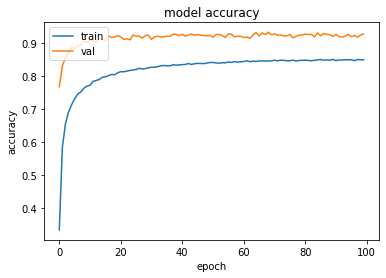

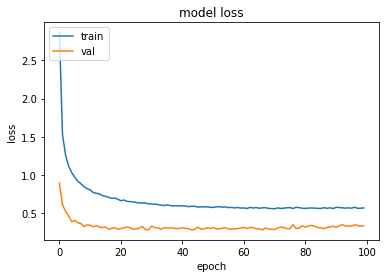

In [ ]:
epochs = 100
batch_size = 256

inputs = pretrained_model.input
x = processing_layers(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)


outputs = Dense(500, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

history = model.fit(
    train_images,
    batch_size = batch_size,
    validation_data=valid_images,
    epochs=epochs,
    callbacks=[
        checkpoint_callback,
    ],
    use_multiprocessing=True
)

time_stamp_name = str(datetime.now()).replace(' ', '_')
model.save(f'/content/drive/My Drive/ml_final/model_bird_{time_stamp_name}.h5')
loaded_model = tf.keras.models.load_model(f'/content/drive/My Drive/ml_final/model_bird_{time_stamp_name}.h5')

results_test = loaded_model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results_test[0]))
print("Test Accuracy: {:.2f}%".format(results_test[1] * 100))

results_valid = loaded_model.evaluate(valid_images, verbose=0)

print("    Validation Set Loss: {:.5f}".format(results_valid[0]))
print("Validation Set Accuracy: {:.2f}%".format(results_valid[1] * 100))

hist_df = pd.DataFrame(history.history) 
hist_df.to_csv(f'/content/drive/My Drive/ml_final/history_{time_stamp_name}.csv')

from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Predict the label of the test_images
pred = loaded_model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

79/79 [==============================] - 10s 116ms/step
The first 5 predictions: ['INDIGO BUNTING', 'INDIGO BUNTING', 'INDIGO BUNTING', 'INDIGO BUNTING', 'INDIGO BUNTING']


In [43]:
classes = list(labels.values())

results_dict = {'test': 0, 'bob': 1}

In [46]:
{k: v for k, v in results_dict.items() if v == 1}

{'bob': 1}

In [ ]:
y_test = list(test_df.Label)
report = classification_report(y_test, pred, output_dict=True)

df_report = pd.DataFrame(report).transpose()


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
df_report

precision  recall  f1-score   support
ABBOTTS BABBLER              0.833333   1.000  0.909091     5.000
ABBOTTS BOOBY                0.800000   0.800  0.800000     5.000
ABYSSINIAN GROUND HORNBILL   1.000000   1.000  1.000000     5.000
AFRICAN CROWNED CRANE        1.000000   1.000  1.000000     5.000
AFRICAN EMERALD CUCKOO       1.000000   0.800  0.888889     5.000
...                               ...     ...       ...       ...
YELLOW CACIQUE               0.714286   1.000  0.833333     5.000
YELLOW HEADED BLACKBIRD      1.000000   1.000  1.000000     5.000
accuracy                     0.934000   0.934  0.934000     0.934
macro avg                    0.944591   0.934  0.931093  2500.000
weighted avg                 0.944591   0.934  0.931093  2500.000

[503 rows x 4 columns]

In [ ]:
df_pr = df_report.drop(df_report.tail(3).index)

In [ ]:
df_pr.describe()

precision      recall    f1-score  support
count  500.000000  500.000000  500.000000    500.0
mean     0.944591    0.934000    0.931093      5.0
std      0.109776    0.138283    0.108805      0.0
min      0.000000    0.000000    0.000000      5.0
25%      1.000000    1.000000    0.888889      5.0
50%      1.000000    1.000000    1.000000      5.0
75%      1.000000    1.000000    1.000000      5.0
max      1.000000    1.000000    1.000000      5.0

In [ ]:
loaded_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_5 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_5[0][0]']            
                                )                                                                 
                                                                                            

In [ ]:
test_df['pred']=pred
test_df.head()

Filepath   Label    pred
0  test/PALILA/2.jpg  PALILA  PALILA
1  test/PALILA/4.jpg  PALILA  PALILA
2  test/PALILA/1.jpg  PALILA  PALILA
3  test/PALILA/5.jpg  PALILA  PALILA
4  test/PALILA/3.jpg  PALILA  PALILA

In [ ]:
len(test_df.Label.unique())

500

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels=test_df.Label.unique()
cf_matrix = confusion_matrix(test_df.Label, test_df.pred, labels=labels)
print(cf_matrix)

df_cm = pd.DataFrame(cf_matrix, columns=labels, index=labels)
df_cm

[[5 0 0 ... 0 0 0]
 [0 4 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 5]]


PALILA  ANDEAN GOOSE  SANDHILL CRANE  PYGMY KINGFISHER  \
PALILA                      5             0               0                 0   
ANDEAN GOOSE                0             4               0                 0   
SANDHILL CRANE              0             0               3                 0   
PYGMY KINGFISHER            0             0               0                 5   
CAMPO FLICKER               0             0               0                 0   
...                       ...           ...             ...               ...   
AZURE JAY                   0             0               0                 0   
STRIPPED SWALLOW            0             0               0                 0   
EASTERN WIP POOR WILL       0             0               0                 0   
AVADAVAT                    0             0               0                 0   
INLAND DOTTEREL             0             0               0                 0   

                       CAMPO FLICKER  AFRICAN OYSTER CATCHER  BLUE DACNIS  \
PALILA                             0                       0            0   
ANDEAN GOOSE                       0                       0            0   
SANDHILL CRANE                     0                       0            0   
PYGMY KINGFISHER                   0                       0            0   
CAMPO FLICKER                      5                       0            0   
...                              ...                     ...          ...   
AZURE JAY                          0                       0            0   
STRIPPED SWALLOW                   0                       0            0   
EASTERN WIP POOR WILL              0                       0            0   
AVADAVAT                           0                       0            0   
INLAND DOTTEREL                    0                       0            0   

                       SAYS PHOEBE  ANTBIRD  ABBOTTS BOOBY  ...  \
PALILA                           0        0              0  ...   
ANDEAN GOOSE                     0        0              0  ...   
SANDHILL CRANE                   0        0              0  ...   
PYGMY KINGFISHER                 0        0              0  ...   
CAMPO FLICKER                    0        0              0  ...   
...                            ...      ...            ...  ...   
AZURE JAY                        0        0              0  ...   
STRIPPED SWALLOW                 0        0              0  ...   
EASTERN WIP POOR WILL            0        0              0  ...   
AVADAVAT                         0        0              0  ...   
INLAND DOTTEREL                  0        0              0  ...   

                       JACOBIN PIGEON  HEPATIC TANAGER  RED BROWED FINCH  \
PALILA                              0                0                 0   
ANDEAN GOOSE                        0                0                 0   
SANDHILL CRANE                      0                0                 0   
PYGMY KINGFISHER                    0                0                 0   
CAMPO FLICKER                       0                0                 0   
...                               ...              ...               ...   
AZURE JAY                           0                0                 0   
STRIPPED SWALLOW                    0                0                 0   
EASTERN WIP POOR WILL               0                0                 0   
AVADAVAT                            0                0                 0   
INLAND DOTTEREL                     0                0                 0   

                       NORTHERN GANNET  PARUS MAJOR  AZURE JAY  \
PALILA                               0            0          0   
ANDEAN GOOSE                         0            0          0   
SANDHILL CRANE                       0            0          0   
PYGMY KINGFISHER                     0            0          0   
CAMPO FLICKER                        0            0          0   
...        

In [ ]:
df_cm_no_5 = df_cm.loc[~(df_cm == 5).any(),:][df_cm.loc[:, ~(df_cm == 5).any()].columns]

In [ ]:
df_cm_no_5

ANDEAN GOOSE  SANDHILL CRANE  BLUE DACNIS  SAYS PHOEBE  \
ANDEAN GOOSE                   4               0            0            0   
SANDHILL CRANE                 0               3            0            0   
BLUE DACNIS                    0               0            4            0   
SAYS PHOEBE                    0               0            0            4   
ANTBIRD                        0               0            0            0   
...                          ...             ...          ...          ...   
EUROPEAN GOLDFINCH             0               0            0            0   
DUSKY ROBIN                    0               0            0            0   
JACOBIN PIGEON                 0               0            0            0   
HEPATIC TANAGER                0               0            0            0   
AVADAVAT                       0               0            0            0   

                    ANTBIRD  ABBOTTS BOOBY  JANDAYA PARAKEET  \
ANDEAN GOOSE              0              0                 0   
SANDHILL CRANE            0              0                 0   
BLUE DACNIS               0              0                 0   
SAYS PHOEBE               0              0                 0   
ANTBIRD                   4              0                 0   
...                     ...            ...               ...   
EUROPEAN GOLDFINCH        0              0                 0   
DUSKY ROBIN               0              0                 0   
JACOBIN PIGEON            0              0                 0   
HEPATIC TANAGER           0              0                 0   
AVADAVAT                  0              0                 0   

                    CRESTED OROPENDOLA  RED LEGGED HONEYCREEPER  \
ANDEAN GOOSE                         0                        0   
SANDHILL CRANE                       0                        0   
BLUE DACNIS                          0                        1   
SAYS PHOEBE                          0                        0   
ANTBIRD                              0                        0   
...                                ...                      ...   
EUROPEAN GOLDFINCH                   0                        0   
DUSKY ROBIN                          0                        0   
JACOBIN PIGEON                       0                        0   
HEPATIC TANAGER                      0                        0   
AVADAVAT                             0                        0   

                    LUCIFER HUMMINGBIRD  ...  EASTERN GOLDEN WEAVER  \
ANDEAN GOOSE                          0  ...                      0   
SANDHILL CRANE                        0  ...                      0   
BLUE DACNIS                           0  ...                      0   
SAYS PHOEBE                           0  ...                      0   
ANTBIRD                               0  ...                      0   
...                                 ...  ...                    ...   
EUROPEAN GOLDFINCH                    0  ...                      0   
DUSKY ROBIN                           0  ...                      0   
JACOBIN PIGEON                        0  ...                      0   
HEPATIC TANAGER                       0  ...                      0   
AVADAVAT                              0  ...                      0   

                    BAY-BREASTED WARBLER  NORTHERN GOSHAWK  \
ANDEAN GOOSE                           0                 0   
SANDHILL CRANE                         0                 0   
BLUE DACNIS                            0                 0   
SAYS PHOEBE                            0                 0   
ANTBIRD                                0                 0   
...                                  ...               ...   
EUROPEAN GOLDFINCH                     0                 0   
DUSKY ROBIN                            0                 0   
JACOBIN PIGEON                         0                 0   
HEPATIC TANAGER                     

In [ ]:
df_cm.sum(axis=1).describe()

count    500.0
mean       5.0
std        0.0
min        5.0
25%        5.0
50%        5.0
75%        5.0
max        5.0
dtype: float64

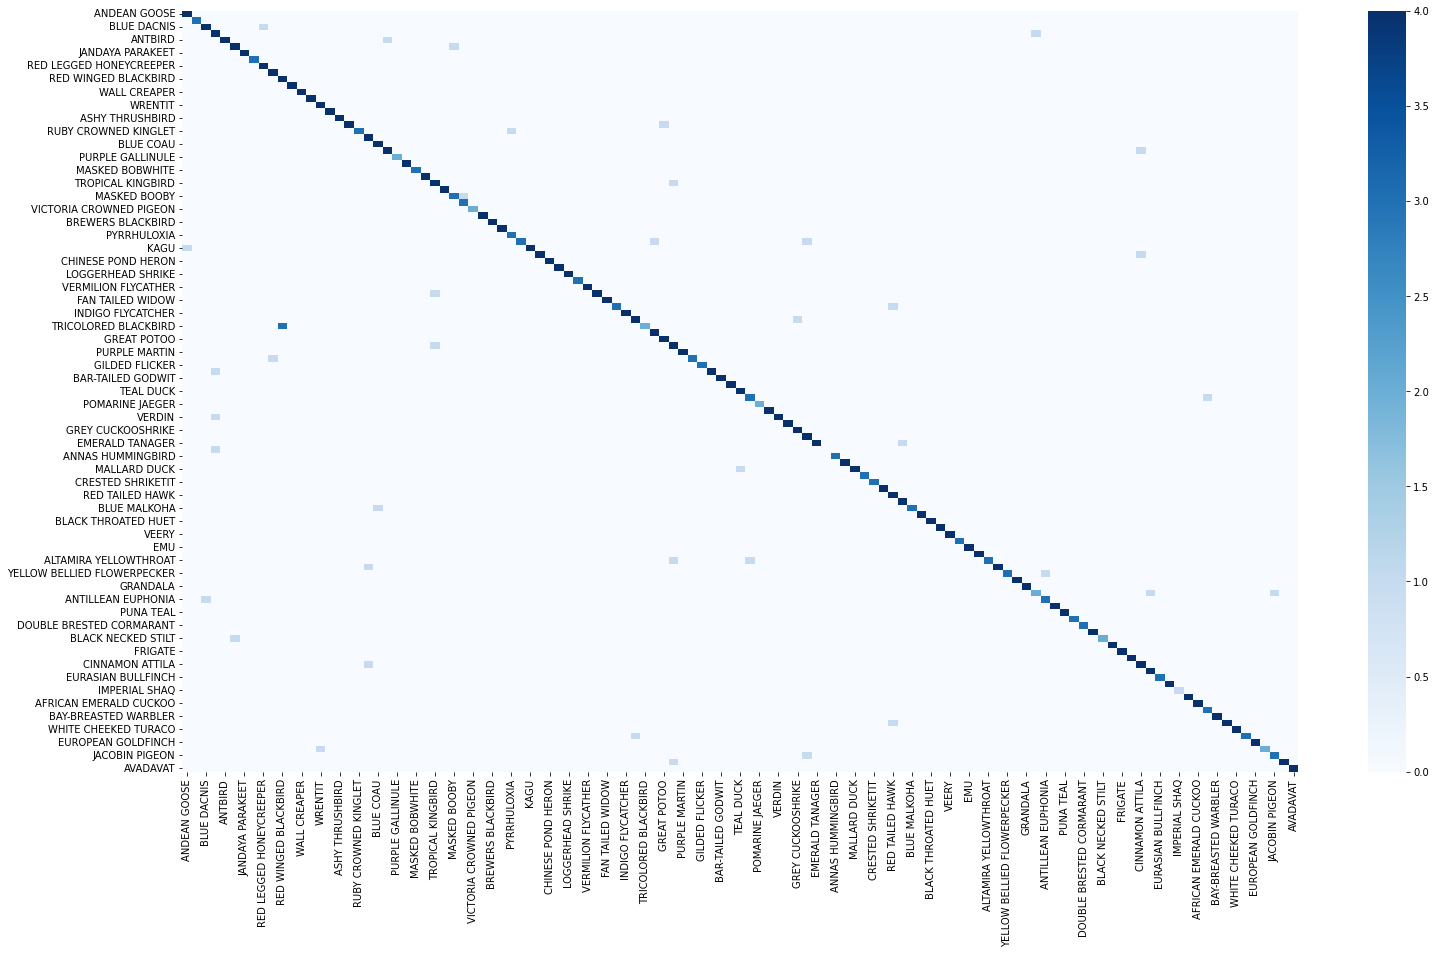

In [ ]:
plt.figure(figsize = (25,14))
sns.heatmap(df_cm_no_5, annot=False, 
            cmap='Blues')

plt.show()